In [295]:
0#Importing Packages

#Data
import pandas as pd
import numpy as np

#ML Frameworks
#scikit learn - library for predictions
#statsmodels - library for models
import sklearn as sk
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels as sm

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


## Understanding Key Drivers of Price

Real estate prices can be seperated effectively in to two distinct categories; **county and metro**. As the location itself acts as a key distinction between the average type, size and price of the property. 

To better understand the market demand, we want to examine the metrics that indicate the prices at which properties are being listed/sold in each particular region. 

The metrics that we want to look at are:
>
 * 'property_type_id': id number indicating which type of property (i.e All Residences, Single Family Homes, Townhouses etc.)
 * 'period_begin': start date
 * 'period_end': end date
 * 'period_duration': duration of the data record
 * 'median_sale_price': median sale price of homes sold
 * 'median_list_price': median list price of homes
 * 'avg_sale_to_list': ratio comparing the sale price and list price
 * 'last_updated' : retreiving the latest updated data
 * 'average annual inflation' : an important factor when the comes to the valuation of USD when purchasing property.



In [296]:
#Data Wrangling from Redfin
url2 = 'https://raw.githubusercontent.com/ayiply/test_repo/main/us_national_market_tracker.tsv000'
national_df = pd.read_csv(url2, sep = "\t")


In [297]:
national_df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2018-10-01,2018-10-31,30,national,11,1400,f,National,National,U.S.,...,-0.010469,0.182812,0.015493,0.042999,0.316318,-0.024323,-0.032624,NaN,NaN,2022-04-10 14:49:10
1,2020-10-01,2020-10-31,30,national,11,1400,f,National,National,U.S.,...,0.054528,0.134954,0.005643,-0.013543,0.358236,-0.015613,0.038912,NaN,NaN,2022-04-10 14:49:10
2,2020-01-01,2020-01-31,30,national,11,1400,f,National,National,U.S.,...,-0.002394,0.108246,0.027181,-0.012040,0.381831,0.139909,0.009160,NaN,NaN,2022-04-10 14:49:10
3,2012-06-01,2012-06-30,30,national,11,1400,f,National,National,U.S.,...,0.035716,0.059756,0.000872,-0.021419,0.292725,-0.015050,0.062571,NaN,NaN,2022-04-10 14:49:10
4,2017-03-01,2017-03-31,30,national,11,1400,f,National,National,U.S.,...,0.013701,0.108722,0.007264,-0.004099,0.466676,0.003419,0.022455,NaN,NaN,2022-04-10 14:49:10


In [298]:
national_df.columns

Index(['period_begin', 'period_end', 'period_duration', 'region_type',
       'region_type_id', 'table_id', 'is_seasonally_adjusted', 'region',
       'city', 'state', 'state_code', 'property_type', 'property_type_id',
       'median_sale_price', 'median_sale_price_mom', 'median_sale_price_yoy',
       'median_list_price', 'median_list_price_mom', 'median_list_price_yoy',
       'median_ppsf', 'median_ppsf_mom', 'median_ppsf_yoy', 'median_list_ppsf',
       'median_list_ppsf_mom', 'median_list_ppsf_yoy', 'homes_sold',
       'homes_sold_mom', 'homes_sold_yoy', 'pending_sales',
       'pending_sales_mom', 'pending_sales_yoy', 'new_listings',
       'new_listings_mom', 'new_listings_yoy', 'inventory', 'inventory_mom',
       'inventory_yoy', 'months_of_supply', 'months_of_supply_mom',
       'months_of_supply_yoy', 'median_dom', 'median_dom_mom',
       'median_dom_yoy', 'avg_sale_to_list', 'avg_sale_to_list_mom',
       'avg_sale_to_list_yoy', 'sold_above_list', 'sold_above_list_mom',
 

In [299]:
national_df[['region']].value_counts()

region   
 National    1353
dtype: int64

In [300]:
def year(str):
    return int(str[:4])

national_df = national_df.assign(year = national_df['period_begin'].apply(year))

In [301]:
national_df = national_df[['property_type_id','period_begin', 'period_end', 'year', 'period_duration' ,'median_list_price','median_sale_price', 'median_list_ppsf', 'avg_sale_to_list', 'last_updated']]

In [302]:
national_df['last_updated'].value_counts().index.tolist()[-1]

'2022-04-11 00:00:00'

In [303]:
national_df['last_updated'].value_counts()

2022-04-10 14:49:10    738
2022-04-11 00:00:00    615
Name: last_updated, dtype: int64

In [304]:
# property_type_id == -1; All residential homes
national_df = national_df.loc[national_df['property_type_id'] == -1]

#Removing Duplicate Entries, Leaving Latest Update
national_df = national_df.loc[national_df['last_updated'] == '2022-04-10 14:49:10']
#national_df = national_df.loc[national_df['last_updated'] == national_df['last_updated'].value_counts().index.tolist()[-1]]

#Sorting by ascending order of entry period end date
national_df.sort_values('period_end', inplace = True)


In [305]:
national_df

,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10
...,...,...,...,...,...,...,...,...,...,...
1014,-1,2021-11-01,2021-11-30,2021,30,371843.0,382460.0,208.0,1.006288,2022-04-10 14:49:10
946,-1,2021-12-01,2021-12-31,2021,30,366811.0,381527.0,208.0,1.004854,2022-04-10 14:49:10
808,-1,2022-01-01,2022-01-31,2022,30,395800.0,376519.0,222.0,1.003992,2022-04-10 14:49:10
1057,-1,2022-02-01,2022-02-28,2022,30,415025.0,388527.0,231.0,1.012548,2022-04-10 14:49:10


In [306]:
#Inflation Data
url3 = 'https://raw.githubusercontent.com/ayiply/test_repo/main/inflation_data.csv'
inflation_df = pd.read_csv(url3)

inflation_df.columns
inflation_df = inflation_df.rename({'inflation rate' : 'inf_rate'}, axis = 'columns' )

inf_dict = dict(zip(inflation_df.year, inflation_df.inf_rate))

inflation_df
base_inflation = inflation_df[inflation_df['year'] > 2011]['amount'].tolist()
base_inflation = [i/base_inflation[0] for i in base_inflation]
base_inflation
year_list = list(range(2012, 2023, 1))
year_list

def total_inflation(year):
    for i in range(12):
        if year == year_list[i]:
            return round(base_inflation[i], 2)
            
national_df = national_df.assign(base_inflation = national_df['year'].apply(total_inflation))

In [307]:
#List for inflation rates by year in period_begin
inflation_column = []

#converting period_begins column into iterable list
ser = pd.DataFrame(national_df, columns = ['period_begin'])
dates = ser.squeeze()
date_list = dates.to_list()

#assigning annual inflation rate based on year found in list of dates' strings
for key in inf_dict:
  for entry in date_list:
    if str(key) in entry:
      inflation_column.append(inf_dict[key])
  
#appending column to national_df
national_df['inflation_by_year'] = inflation_column

In [308]:
national_df

,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated,base_inflation,inflation_by_year
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10,1.00,0.02
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10,1.00,0.02
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10,1.00,0.02
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10,1.00,0.02
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10,1.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...
1014,-1,2021-11-01,2021-11-30,2021,30,371843.0,382460.0,208.0,1.006288,2022-04-10 14:49:10,1.18,0.05
946,-1,2021-12-01,2021-12-31,2021,30,366811.0,381527.0,208.0,1.004854,2022-04-10 14:49:10,1.18,0.05
808,-1,2022-01-01,2022-01-31,2022,30,395800.0,376519.0,222.0,1.003992,2022-04-10 14:49:10,1.26,0.07
1057,-1,2022-02-01,2022-02-28,2022,30,415025.0,388527.0,231.0,1.012548,2022-04-10 14:49:10,1.26,0.07


In [309]:
national_df = national_df.assign(adjusted_median_list_price = national_df['median_list_price'] / national_df['base_inflation'])
national_df = national_df.assign(adjusted_median_sale_price = national_df['median_sale_price'] / national_df['base_inflation'])
national_df = national_df.assign(adjusted_median_list_ppsf = national_df['median_list_ppsf'] / national_df['base_inflation'])
national_df.head()

,property_type_id,period_begin,period_end,year,period_duration,median_list_price,median_sale_price,median_list_ppsf,avg_sale_to_list,last_updated,base_inflation,inflation_by_year,adjusted_median_list_price,adjusted_median_sale_price,adjusted_median_list_ppsf
1028,-1,2012-01-01,2012-01-31,2012,30,182741.0,158955.0,102.0,0.956285,2022-04-10 14:49:10,1.0,0.02,182741.0,158955.0,102.0
1016,-1,2012-02-01,2012-02-29,2012,30,192252.0,159915.0,105.0,0.958041,2022-04-10 14:49:10,1.0,0.02,192252.0,159915.0,105.0
337,-1,2012-03-01,2012-03-31,2012,30,198860.0,170681.0,108.0,0.961785,2022-04-10 14:49:10,1.0,0.02,198860.0,170681.0,108.0
1080,-1,2012-04-01,2012-04-30,2012,30,198927.0,177774.0,107.0,0.965150,2022-04-10 14:49:10,1.0,0.02,198927.0,177774.0,107.0
539,-1,2012-05-01,2012-05-31,2012,30,200718.0,186050.0,108.0,0.968565,2022-04-10 14:49:10,1.0,0.02,200718.0,186050.0,108.0


# **Notes for the team:** 
So the national_df DataFrame contains aggregate values for all residential homes across the US. Potentially if we wanted to look at specific states (like California, Washington, etc) there are more data for location specific metrics which we can further investigate. 

In [310]:
X = national_df['median_list_price']
y = national_df['median_sale_price']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
     


In [311]:
regr = linear_model.LinearRegression()
regr.fit(np.array(X_train).reshape(-1,1), y_train)
housing_pred = regr.predict(np.array(X_test).reshape(-1,1))
print("Mean squared error: %.2f" % mean_squared_error(y_test, housing_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, housing_pred))

Mean squared error: 141573677.73
Coefficient of determination: 0.96


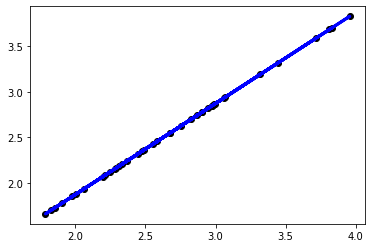

In [312]:
X_test_norm = X_test.apply(lambda x: x/100000)
housing_pred_norm = np.array([(pred / 100000) for pred in housing_pred])

plt.scatter(X_test_norm, housing_pred_norm, color="black")
plt.plot(X_test_norm, housing_pred_norm, color="blue", linewidth=3)

In [313]:
regr.score(np.array(X_test).reshape(-1,1), y_test)

0.9556210302546702

<AxesSubplot:xlabel='adjusted_median_list_price', ylabel='adjusted_median_sale_price'>

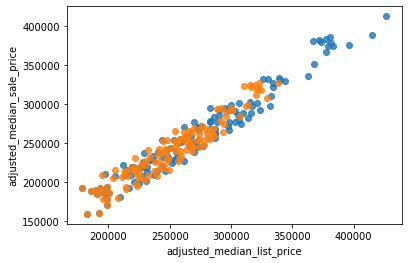

In [314]:
sns.regplot(x = "median_list_price", y = "median_sale_price", data = national_df, fit_reg=False)
sns.regplot(x = "adjusted_median_list_price", y = "adjusted_median_sale_price", data = test, fit_reg=False)

<AxesSubplot:xlabel='year', ylabel='adjusted_median_list_ppsf'>

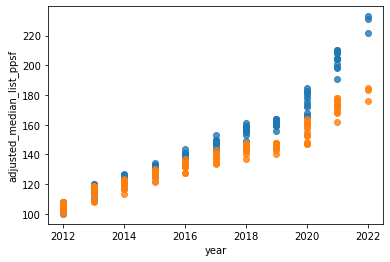

In [315]:
sns.regplot(x = "year", y = "median_list_ppsf", data = national_df, fit_reg=False)
sns.regplot(x = "year", y = "adjusted_median_list_ppsf", data = test, fit_reg=False)

In [335]:
X = national_df['year']
y = national_df['adjusted_median_list_ppsf']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)
     

sorted_index = np.argsort(X_train)
X_train = X_train.to_numpy()[sorted_index]
y_train = y_train.to_numpy()[sorted_index]

sorted_index = np.argsort(X_test)
X_test = X_test.to_numpy()[sorted_index]
y_test = y_test.to_numpy()[sorted_index]

degrees = [1, 2, 3, 6, 10, 20]

y_pred = np.zeros((len(X_train), len(degrees)))

for i, degree in enumerate(degrees):
    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_pred[:, i] = model.predict(np.array(X_train).reshape(-1,1))
    

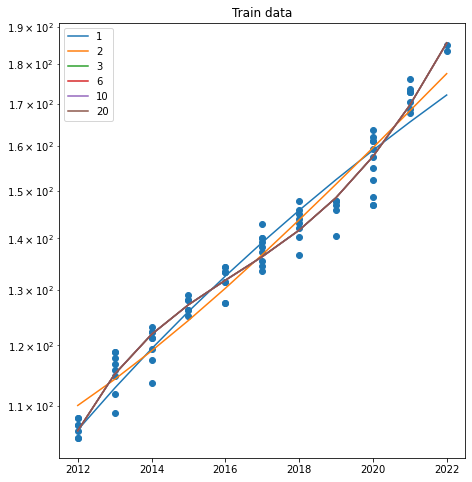

In [336]:
plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.plot(X_train, y_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

In [337]:
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    train_r2 = round(sk.metrics.r2_score(y_train, y_pred[:, i]), 3)
    print("Polynomial degree {0}: score={1}".format(degree, train_r2)) 
                                                                        

R-squared values: 

Polynomial degree 1: score=0.94
Polynomial degree 2: score=0.952
Polynomial degree 3: score=0.968
Polynomial degree 6: score=0.968
Polynomial degree 10: score=0.968
Polynomial degree 20: score=0.968
